In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import math
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import yfinance as yf
import datetime
import os
import torch
from torch.utils.data import Dataset
import yfinance as yf
import datetime

class ExcessReturnDataset(Dataset):
    def __init__(self, seq_len=50, mode='train'):
        self.seq_len = seq_len

        # Date ranges
        start_date = '2019-01-01'
        end_date = '2024-12-18'

        btc_file = 'btc_data.csv'
        spy_file = 'spy_data.csv'
        
        # Check if local files exist
        if os.path.exists(btc_file) and os.path.exists(spy_file):
            btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
            spy_data = yf.download('SPY', start=start_date, end=end_date)
        else:
            # Download data from yfinance if files don't exist
            btc_data = yf.download('BTC-USD', start=start_date, end=end_date)
            spy_data = yf.download('SPY', start=start_date, end=end_date)
            
            # Save to CSV for future runs
            btc_data.to_csv(btc_file)
            spy_data.to_csv(spy_file)

        # If the files exist but are outdated or user wants to ensure no re-download:
        # You could load directly from CSV if you'd prefer:
        # btc_data = pd.read_csv(btc_file, index_col=0, parse_dates=True)
        # spy_data = pd.read_csv(spy_file, index_col=0, parse_dates=True)
        #
        # But here we assume using the downloaded dataframes is fine.

        # Align by joining on common dates
        combined = btc_data[['Close']].rename(columns={'Close': 'BTC_Close'}).join(
            spy_data[['Close']].rename(columns={'Close':'SPY_Close'}), how='inner'
        )

        # Drop rows with any NaN values
        combined = combined.dropna()

        # Extract arrays
        btc_prices = combined['BTC_Close'].values
        spy_prices = combined['SPY_Close'].values
        dates = combined.index

        # Compute daily returns: return[t] = (price[t] / price[t-1]) - 1
        btc_returns = btc_prices[1:] / btc_prices[:-1] - 1
        spy_returns = spy_prices[1:] / spy_prices[:-1] - 1
        excess_returns = btc_returns - spy_returns
        returns_dates = dates[1:]

        # Define date boundaries for splits
        train_end = datetime.datetime(2021,1,1)
        val_end = datetime.datetime(2022,1,1)
        test_end = datetime.datetime(2024,12,18)
        
        if mode == 'train':
            mask = (returns_dates >= datetime.datetime(2019,1,1)) & (returns_dates < train_end)
        elif mode == 'val':
            mask = (returns_dates >= train_end) & (returns_dates < val_end)
        else:  # 'test'
            mask = (returns_dates >= val_end) & (returns_dates <= test_end)

        filtered_returns = excess_returns[mask]
        self.data = torch.tensor(filtered_returns, dtype=torch.float32)
        
        # Store corresponding dates for plotting or reference
        self.dates = returns_dates[mask]

    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]    # (seq_len,)
        y = self.data[idx+self.seq_len]        # scalar (next day's excess return)
        return x.unsqueeze(-1), y.unsqueeze(-1)  # (seq_len, 1), (1,)



# Example usage:
# train_dataset = ExcessReturnDataset(seq_len=50, mode='train')
# val_dataset = ExcessReturnDataset(seq_len=50, mode='val')
# test_dataset = ExcessReturnDataset(seq_len=50, mode='test')

#####################################
# GBM-Based Synthetic Dataset
#####################################
class GBMDataset(Dataset):
    def __init__(self, length=5000, seq_len=50, S0=100, mu=0.05, sigma=0.2, dt=1/252):
        self.seq_len = seq_len
        total_length = length + seq_len
        # Generate GBM prices
        prices = torch.zeros(total_length)
        prices[0] = S0
        for t in range(1, total_length):
            Z = torch.randn(1)
            prices[t] = prices[t-1] * torch.exp((mu - 0.5 * sigma**2)*dt + sigma*math.sqrt(dt)*Z)
        self.data = prices
        
    def __len__(self):
        return len(self.data) - self.seq_len
    
    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_len]
        y = self.data[idx+self.seq_len]
        # x: (seq_len,), y: scalar
        return x.unsqueeze(-1), y.unsqueeze(-1)  # (seq_len,1), (1,)

#####################################
# LSTM Model
#####################################
class TwoLayerLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, output_size=1):
        super(TwoLayerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        last_out = out[:, -1, :]
        preds = self.fc(last_out)
        return preds

#####################################
# Predict and Plot Function
#####################################
def predict_and_plot(model, test_dataset, N=200, epoch_index=None):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for i in range(min(len(test_dataset), N)):
            features, target = test_dataset[i]
            features = features.unsqueeze(0).to(device)  # move features to the same device
            pred = model(features)
            predictions.append(pred.item())
            actuals.append(target.item())
    
    plt.figure(figsize=(10,5))
    plt.plot(range(len(actuals)), actuals, label='Actual', color='blue')
    plt.plot(range(len(predictions)), predictions, label='Predicted', color='red', linestyle='--')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Time Step')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Save the plot 
    plt.savefig(f'actual_vs_predicted_{epoch_index}.png')
    model.train()
    
    
#####################################
# Sharpe Ratio Function
#####################################
def sharpe_ratio(returns):
    mean_ret = torch.mean(returns)
    std_ret = torch.std(returns)
    if std_ret == 0:
        return torch.tensor(0.0, device=returns.device)
    return mean_ret / std_ret


#####################################
# Helper: Compute Gradient Norm
#####################################
def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item()**2
    return total_norm**0.5

def evaluate_metrics(model, data_loader):
    model.eval()
    mse_list = []
    dir_list = []
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(device)
            targets = targets.to(device)

            preds = model(features)  # preds are returns directly
            mse = criterion_mse(preds, targets)

            predicted_returns = preds.squeeze()    # shape: (batch,)
            actual_returns = targets.squeeze()      # shape: (batch,)

            # Actual direction: -1 if negative, +1 if positive
            actual_direction = torch.where(actual_returns >= 0,
                                           torch.tensor(1.0, device=device),
                                           torch.tensor(-1.0, device=device))
            
            # Predicted direction: -1 if negative, +1 if positive
            predicted_direction = torch.where(predicted_returns >= 0,
                                              torch.tensor(1.0, device=device),
                                              torch.tensor(-1.0, device=device))

            dir_loss = criterion_mse(predicted_direction, actual_direction)

            mse_list.append(mse.item())
            dir_list.append(dir_loss.item())

    return (sum(mse_list)/len(mse_list),
            sum(dir_list)/len(dir_list))

In [10]:
#####################################
# Prepare Data
#####################################

train_dataset = ExcessReturnDataset(seq_len=50, mode='train')
val_dataset = ExcessReturnDataset(seq_len=50, mode='val')
test_dataset = ExcessReturnDataset(seq_len=50, mode='test')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


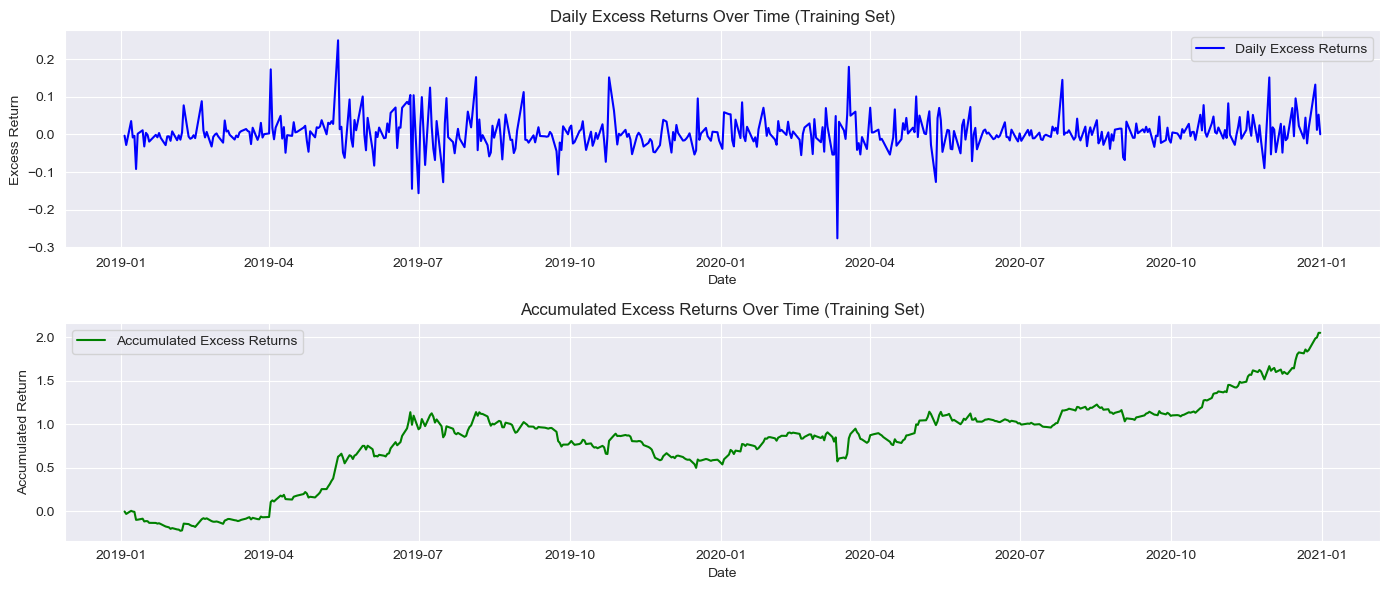

In [11]:
# Extract returns and dates
train_returns = train_dataset.data.cpu().numpy()
train_dates = train_dataset.dates  # This should be a pandas DatetimeIndex or similar

# Compute accumulated returns (cumulative sum)
accumulated_returns = train_returns.cumsum()

plt.figure(figsize=(14,6))

# Plot daily returns
plt.subplot(2,1,1)
plt.plot(train_dates, train_returns, label='Daily Excess Returns', color='blue')
plt.title('Daily Excess Returns Over Time (Training Set)')
plt.xlabel('Date')
plt.ylabel('Excess Return')
plt.grid(True)
plt.legend()

# Plot accumulated returns
plt.subplot(2,1,2)
plt.plot(train_dates, accumulated_returns, label='Accumulated Excess Returns', color='green')
plt.title('Accumulated Excess Returns Over Time (Training Set)')
plt.xlabel('Date')
plt.ylabel('Accumulated Return')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
#####################################
# Training Setup
#####################################

seq_len = 50
batch_size = 32
learning_rate = 0.001
k_tanh = 100  # hyperparameter controlling the steepness of the tanh curve


# Check if GPU is available and set device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TwoLayerLSTM(input_size=1, hidden_size=32, num_layers=2, output_size=1)
model.to(device)

# Also, ensure your loss function and optimizer remain the same
criterion_mse = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Histories for plotting
train_mse_history = []
val_mse_history = []
train_sr_history = []
val_sr_history = []
train_dir_history = []
val_dir_history = []

lambda_sr = 0.1  # initial guess (will be adjusted)
lambda_dir = 0.1 # initial guess (will be adjusted)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# Hyperparameters for smoothing
update_interval = 10  # Update lambda coefficients every 10 batches
epochs = 3000   # example number of epochs
# Accumulators
gradnorm_mse_accum = 0.0
gradnorm_dir_accum = 0.0
count_accum = 0

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    epoch_mse = 0.0
    epoch_dir_loss = 0.0
    count = 0
    
    for i, (features, targets) in enumerate(train_loader):
        # Add a batch dimension:
        features = features.to(device)   # Already (batch_size, seq_len, 1)
        targets = targets.to(device)     # Already (batch_size, 1)
        optimizer.zero_grad()
        
        # Forward pass
        preds = model(features)
        
        # Since we're in return space:
        predicted_returns = preds.squeeze()    # shape: (batch,)
        actual_returns = targets.squeeze()      # shape: (batch,)
        
        # Compute MSE
        mse_loss = criterion_mse(predicted_returns, actual_returns)

        # Directionality:
        # Actual direction: +1 if actual_returns >=0, else -1
        
        actual_direction = torch.where(actual_returns >= 0,
                                       torch.tensor(1.0, device=device),
                                       torch.tensor(-1.0, device=device))
        # Predicted direction using tanh approximation
        predicted_direction = torch.tanh(k_tanh * predicted_returns)
        directional_loss = criterion_mse(predicted_direction, actual_direction)


        # Compute gradient norms for each loss separately

        # 1) MSE gradient norm
        optimizer.zero_grad()
        mse_loss.backward(retain_graph=True)
        gradnorm_mse = compute_grad_norm(model)

        # 2) Directional loss gradient norm
        optimizer.zero_grad()
        directional_loss.backward(retain_graph=True)
        gradnorm_dir = compute_grad_norm(model)
        
        # Accumulate gradient norms for smoothing
        gradnorm_mse_accum += gradnorm_mse
        gradnorm_dir_accum += gradnorm_dir
        count_accum += 1
        
        # Only update lambdas after every `update_interval` batches
        if count_accum == update_interval:
            avg_gradnorm_mse = gradnorm_mse_accum / count_accum
            avg_gradnorm_dir = gradnorm_dir_accum / count_accum

            if avg_gradnorm_dir > 1e-12:
                lambda_dir = avg_gradnorm_mse / avg_gradnorm_dir
            # else keep lambda_dir same
            # print(f"Updated lambda_dir: {lambda_dir:.4f}")

            # Reset accumulators
            gradnorm_mse_accum = 0.0
            gradnorm_dir_accum = 0.0
            count_accum = 0



        # Final combined loss:
        # L = MSE  lambda_dir * Directional_loss
        optimizer.zero_grad()
        preds = model(features)
        predicted_returns = preds.squeeze()
        actual_returns = targets.squeeze()

        mse_loss = criterion_mse(predicted_returns, actual_returns)
        actual_direction = torch.where(actual_returns >= 0,
                                       torch.tensor(1.0, device=device),
                                       torch.tensor(-1.0, device=device))
        predicted_direction = torch.tanh(k_tanh * predicted_returns)
        directional_loss = criterion_mse(predicted_direction, actual_direction)

        loss = mse_loss + lambda_dir * directional_loss
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_mse += mse_loss.item()
        epoch_dir_loss += directional_loss.item()
        count += 1

    avg_loss = epoch_loss / count
    avg_mse = epoch_mse / count
    avg_dir_loss = epoch_dir_loss / count
    print(f"Epoch [{epoch}/{epochs}] - Combined Loss: {avg_loss:.4f}, MSE: {avg_mse:.4f},  Dir Loss: {avg_dir_loss:.4f}")
    
    # Every 100 epochs, do a prediction and plot
    if epoch % 100 == 0:
        predict_and_plot(model, test_dataset, N=200)
    
    if epoch % 100 == 0:
    # Save model parameters
        torch.save(model.state_dict(), f"model_epoch_{epoch}.pth")
        print(f"Model weights saved at epoch {epoch}")

Epoch [1/3000] - Combined Loss: 41.1495, MSE: 0.0118,  Dir Loss: 1.9957
Epoch [2/3000] - Combined Loss: 19.3775, MSE: 0.0025,  Dir Loss: 1.7621
Epoch [3/3000] - Combined Loss: 0.1677, MSE: 0.0039,  Dir Loss: 2.0899
Epoch [4/3000] - Combined Loss: 1.4851, MSE: 0.0045,  Dir Loss: 2.0913
Epoch [5/3000] - Combined Loss: 3.5642, MSE: 0.0047,  Dir Loss: 2.1636
Epoch [6/3000] - Combined Loss: 3.7415, MSE: 0.0054,  Dir Loss: 2.0192
Epoch [7/3000] - Combined Loss: 4.5566, MSE: 0.0049,  Dir Loss: 2.0914
Epoch [8/3000] - Combined Loss: 4.3853, MSE: 0.0049,  Dir Loss: 2.0553
Epoch [9/3000] - Combined Loss: 4.1905, MSE: 0.0047,  Dir Loss: 2.0553
Epoch [10/3000] - Combined Loss: 4.2352, MSE: 0.0050,  Dir Loss: 2.1275
Epoch [11/3000] - Combined Loss: 4.1640, MSE: 0.0047,  Dir Loss: 2.0553
Epoch [12/3000] - Combined Loss: 4.1416, MSE: 0.0047,  Dir Loss: 2.0914
Epoch [13/3000] - Combined Loss: 4.0511, MSE: 0.0047,  Dir Loss: 2.0553
Epoch [14/3000] - Combined Loss: 4.0573, MSE: 0.0047,  Dir Loss: 2.0914

KeyboardInterrupt: 

In [ ]:
# After training, plot the history of MSE, SR, and Directional Loss for both train and val
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(train_mse_history, label='Train MSE')
plt.plot(val_mse_history, label='Val MSE')
plt.title('MSE Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()

plt.subplot(1,3,2)
plt.plot(train_sr_history, label='Train SR')
plt.plot(val_sr_history, label='Val SR')
plt.title('Sharpe Ratio Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('SR')
plt.legend()

plt.subplot(1,3,3)
plt.plot(train_dir_history, label='Train Dir Loss')
plt.plot(val_dir_history, label='Val Dir Loss')
plt.title('Directional Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()